In [6]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import util.functions as funcs

SEED = 10
np.random.seed = SEED

[*********************100%***********************]  1 of 1 completed


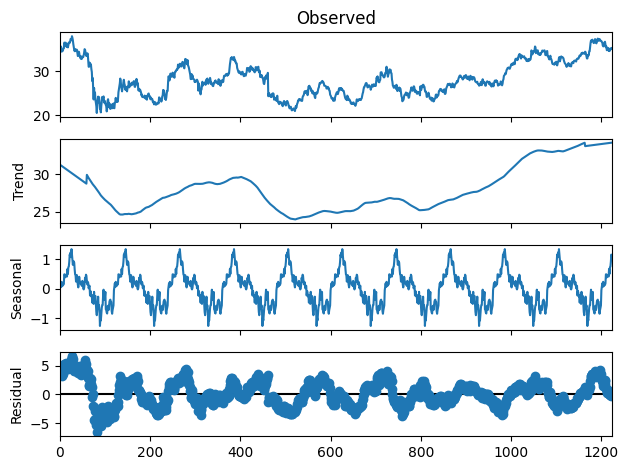

In [3]:
EMPRESA = 'ITUB4.SA'

df_full = funcs.get_data_ticker(EMPRESA, period='5y')
df = df_full.dropna()

dates, X, y = funcs.split_df_X_y(df)

result = seasonal_decompose(y, period=120, extrapolate_trend='freq')

metric = result.observed

result.plot()
plt.show()

In [5]:
data_hist = pd.DataFrame()
data_hist['metric'] = metric

data_hist['mm5'] = data_hist['metric'].rolling(5).mean()
data_hist['mm15'] = data_hist['metric'].rolling(15).mean()
data_hist['mm30'] = data_hist['metric'].rolling(30).mean()

data_hist = data_hist.dropna()

X = data_hist.iloc[:, 1:]
y = data_hist.iloc[:, 0]

scaler = StandardScaler()
#X = scaler.fit_transform(X)


pctTreino = .8

X_train, y_train = X[:int(len(X) * pctTreino)], y.iloc[:int(len(y) * pctTreino)]  
X_test, y_test = X[int(len(X) * pctTreino):], y.iloc[int(len(y) * pctTreino):]   

Configurando Random Search

In [9]:
# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros e os intervalos para o Random Search
param_distributions = {
    'C': np.logspace(-2, 3, 10),  # [0.01, 0.1, 1, 10, 100, 1000]
    'epsilon': np.logspace(-3, 0, 10),  # [0.001, 0.01, 0.1, 1]
    'kernel': ['poly', 'rbf']  # Pode incluir outros kernels se quiser
}

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_distributions,
    n_iter=20,  # Número de combinações a serem testadas
    cv=5,  # Validação cruzada com 5 folds
    verbose=2,  # Para acompanhar o progresso
    n_jobs=-1,  # Usar todos os núcleos do processador
    random_state=SEED
)


In [10]:
# Treinar o modelo com Random Search
random_search.fit(X_train, y_train)

# Melhor conjunto de parâmetros
print("Melhores hiperparâmetros encontrados:", random_search.best_params_)

# Avaliar o modelo no conjunto de teste
y_pred = random_search.predict(X_test)
r2 = r2_score(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)


print(f"r2: {r2}\n")
print(f"mae: {mae}\n")
print(f"mse: {mse}\n")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros encontrados: {'kernel': 'poly', 'epsilon': 0.046415888336127774, 'C': 0.01}
r2: 0.7185300298194748

mae: 1.0890819681146133

mse: 2.093875197075303

[CV] END ......C=0.1291549665014884, epsilon=1.0, kernel=rbf; total time=   0.1s
[CV] END ...C=0.01, epsilon=0.004641588833612777, kernel=rbf; total time=   0.1s
[CV] END ...C=0.01, epsilon=0.004641588833612777, kernel=rbf; total time=   0.1s
[CV] END ..C=0.03593813663804628, epsilon=0.001, kernel=poly; total time=  20.1s
[CV] END .................C=1000.0, epsilon=1.0, kernel=poly; total time= 1.9min
[CV] END .................C=1000.0, epsilon=1.0, kernel=poly; total time= 2.1min
[CV] END ....................C=0.01, epsilon=1.0, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, epsilon=1.0, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, epsilon=1.0, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01